## Segmenting users based on their usage data.

before doing anything, let me introduce the dataset. This dataset is about 10,000 usaers product usage for 579 days. Goal of this notebook is, find simmilar usage pattersn and group them according to that pattern.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import DBSCAN,OPTICS,KMeans,AffinityPropagation
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.decomposition import PCA,FactorAnalysis
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
import umap.umap_ as umap

sys.path.append("../")
from helpers import plot_ts_cluster_results
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_parquet(r"..\creds and datasets\sample_10_000_preprocessed.parquet")

In [3]:
df.columns = ['uid','usage']

In [4]:
df.head()

,uid,usage
2020-06-01,2860,0
2020-06-01,5126,0
2020-06-01,9047,0
2020-06-01,9900,114
2020-06-01,2406,0


In [5]:
df.shape

(5790000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5790000 entries, 2020-06-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int16
 1   usage   int32
dtypes: int16(1), int32(1)
memory usage: 77.3 MB


Creating training dataset

In [7]:
train = df.pivot_table(index='uid',columns=df.index,values='usage')
train.columns = range(len(train.columns))
train.index.name = None
train.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,255,0,0,0,0,0,176,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1100,1726,1243,1426,1366,1215,859,1772,0,1099
3,0,0,0,0,0,0,0,0,0,0,...,341,647,634,46,32,284,374,451,0,1006
4,0,0,0,0,0,0,0,0,0,0,...,304,0,323,88,22,295,413,392,0,114


In [8]:
train.shape

(10000, 579)

In [9]:
sample_users = train.sample(10).values

Let's plot some usage data.

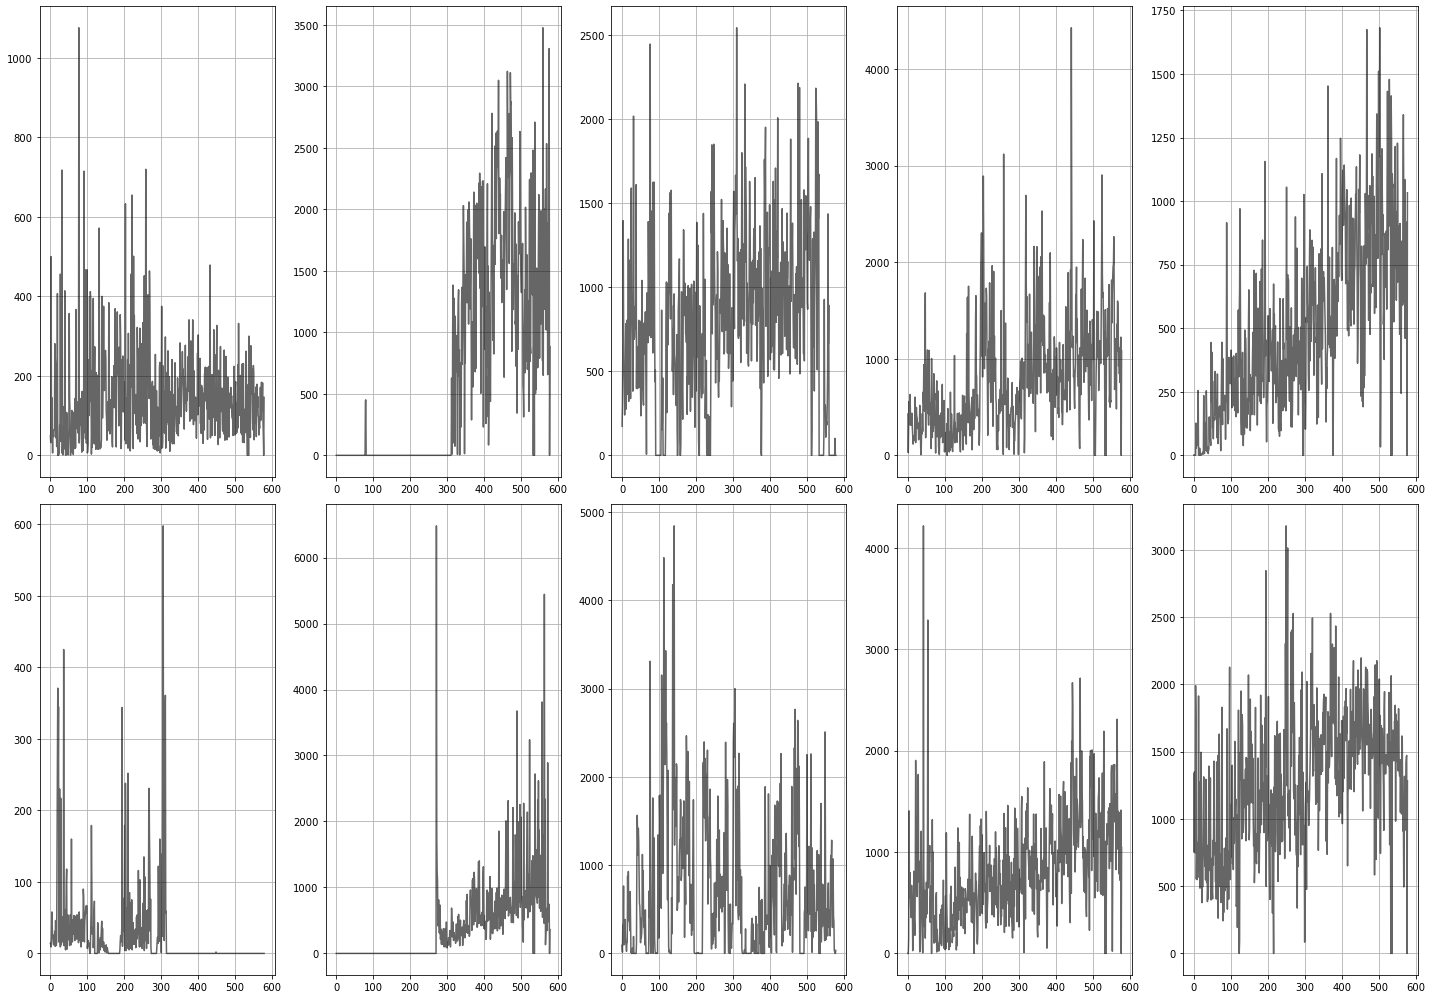

In [10]:
_,ax = plt.subplots(2,5,figsize=(20,14))
ax = ax.flatten()

for i,usage_info in enumerate(sample_users):
    ax[i].plot(usage_info,color='black',alpha=0.6)
    ax[i].grid(True)

plt.tight_layout()
plt.show()

In [11]:
del sample_users
del df

As you can see in the above plot, we have deferent users with deferent usage pattern and deferent scale of usage.

New we can move to the modeling part. Since all features are same usage info, I'm not going to scale the dataset.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 579 entries, 0 to 578
dtypes: int32(579)
memory usage: 22.2 MB


Let's quickly check the sparcity of data.

In [13]:
np.count_nonzero(train.values)/np.size(train.values)

0.719566493955095

Since it's somewhere around 72% not going to convert it to a sparse metrics.

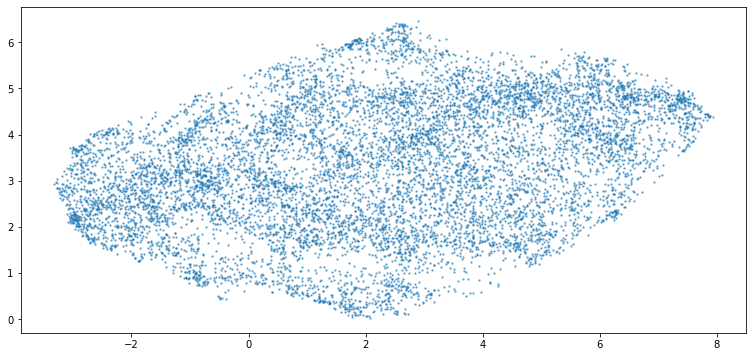

In [14]:
clusterable_embedding = umap.UMAP(
    n_components=2,
    random_state=42,
).fit_transform(train.values)

plt.figure(figsize=(13,6))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],s=2, cmap='viridis',alpha=0.5)
plt.show()

As we can see above plot, this dataset is not good enough to make an usable clusters. Let's add some more features. Let't try other way to do this.

In [15]:
train['max'] = train.apply(lambda x:max(x),axis=1)
train['average'] = train.apply(lambda x:np.mean(x),axis=1)
train['non_zeros'] = train.apply(lambda x:np.count_nonzero(x),axis=1)

In [16]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,max,average,non_zeros
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2574,213.839655,152
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,176,0,0,3961,551.479310,360
2,0,0,0,0,0,0,0,0,0,0,...,1426,1366,1215,859,1772,0,1099,5682,487.368966,226
3,0,0,0,0,0,0,0,0,0,0,...,46,32,284,374,451,0,1006,5597,319.425862,428
4,0,0,0,0,0,0,0,0,0,0,...,88,22,295,413,392,0,114,5050,516.905172,351


Since my requrement is segregrate customers based on usage value and usage pattern, we can use some simple method as follows.

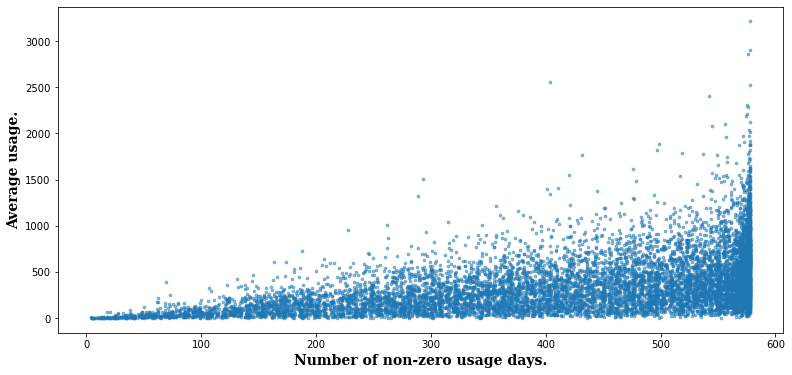

In [17]:
plt.figure(figsize=(13,6))
plt.scatter(train['non_zeros'],train['average'],s=7, cmap='viridis',alpha=0.5)
plt.ylabel("Average usage.",fontsize=14,fontfamily='serif',fontweight='semibold')
plt.xlabel("Number of non-zero usage days.",fontsize=14,fontfamily='serif',fontweight='semibold')
plt.show()

Here I'm going to cluster used based on non_zero usage days and their average usage.

In [18]:
labs = KMeans(4).fit_predict(train[['non_zeros','average']])

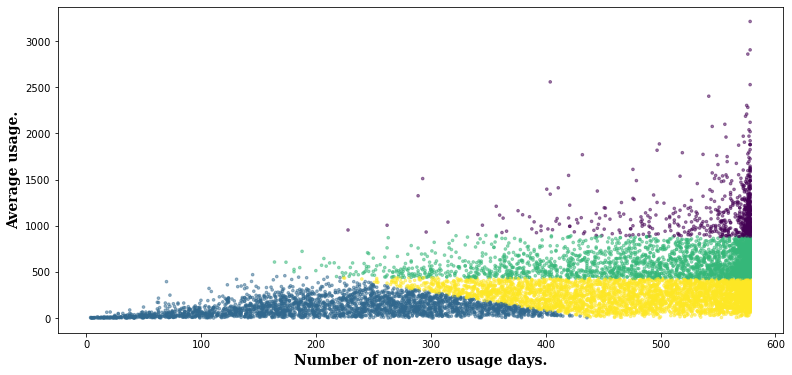

In [19]:
plt.figure(figsize=(13,6))
plt.scatter(train['non_zeros'],train['average'],s=7,c=labs, cmap='viridis',alpha=0.5)
plt.ylabel("Average usage.",fontsize=14,fontfamily='serif',fontweight='semibold')
plt.xlabel("Number of non-zero usage days.",fontsize=14,fontfamily='serif',fontweight='semibold')
plt.show()

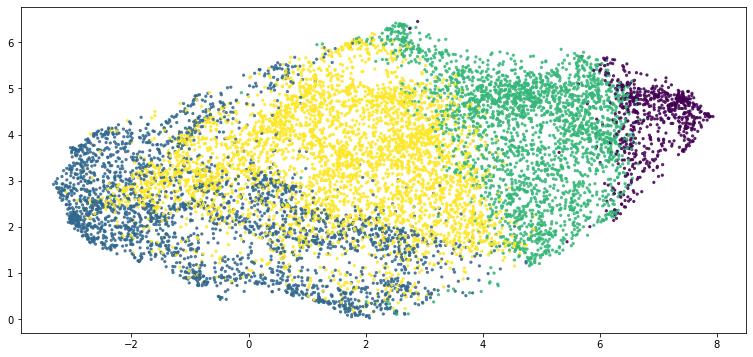

In [20]:
plt.figure(figsize=(13,6))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],c=labs,s=5, cmap='viridis',alpha=0.8)
plt.show()

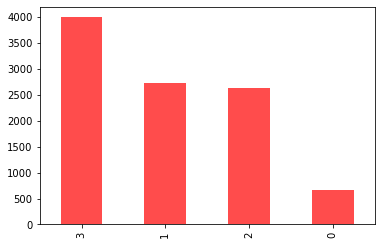

In [21]:
train['segment'] = labs
ax = train['segment'].value_counts().plot.bar(color='r',alpha=0.7)
plt.show()

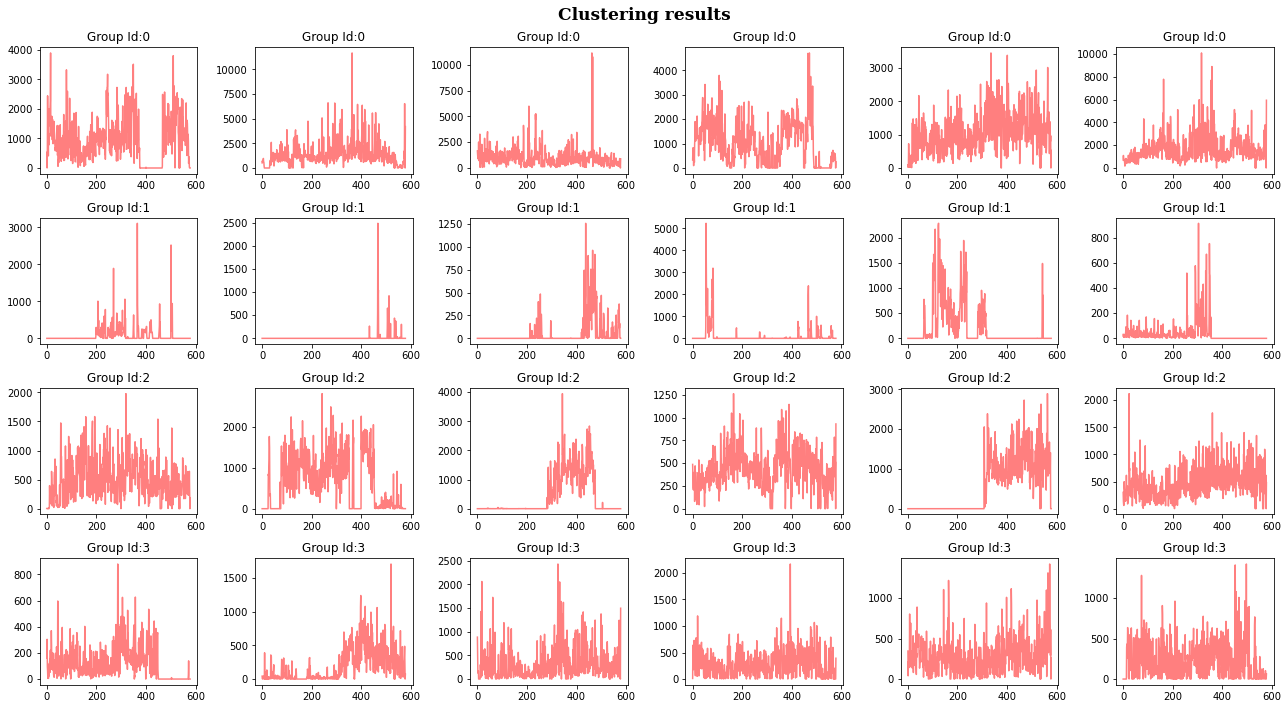

In [22]:
n = 6
fig,ax = plt.subplots(len(np.unique(labs)),n,figsize=(18,10))

u00 = train.query("segment==0")[range(579)].sample(n).values
u01 = train.query("segment==1")[range(579)].sample(n).values
u02 = train.query("segment==2")[range(579)].sample(n).values
u03 = train.query("segment==3")[range(579)].sample(n).values

for i,g in enumerate([u00,u01,u02,u03]):
    for j,usage in enumerate(g):
        ax[i][j].set_title(f"Group Id:{i}")
        ax[i][j].plot(usage,color='r',alpha=0.5)

fig.suptitle('Clustering results',fontfamily='serif',fontsize='17',fontweight='semibold')
plt.tight_layout()
plt.show()

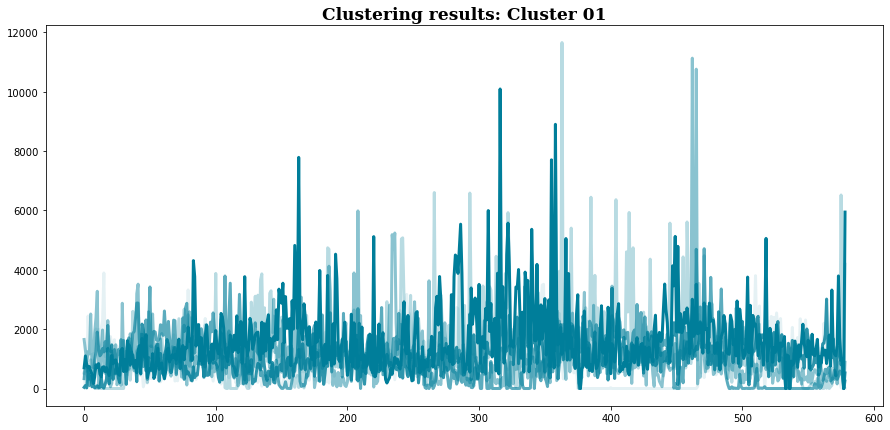

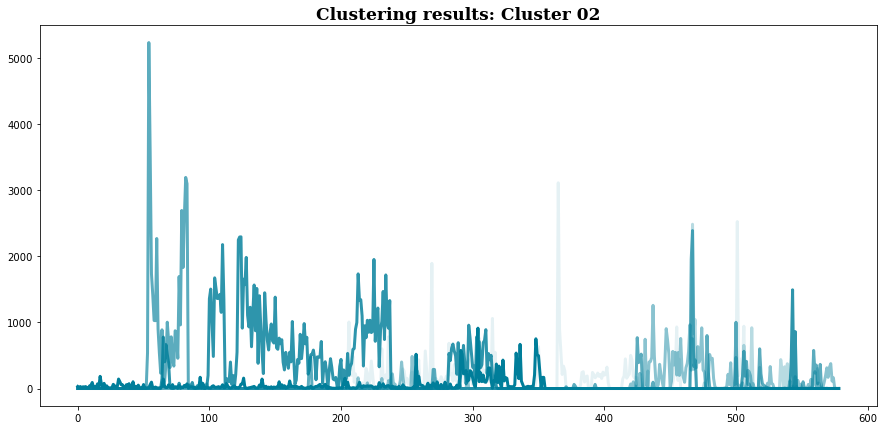

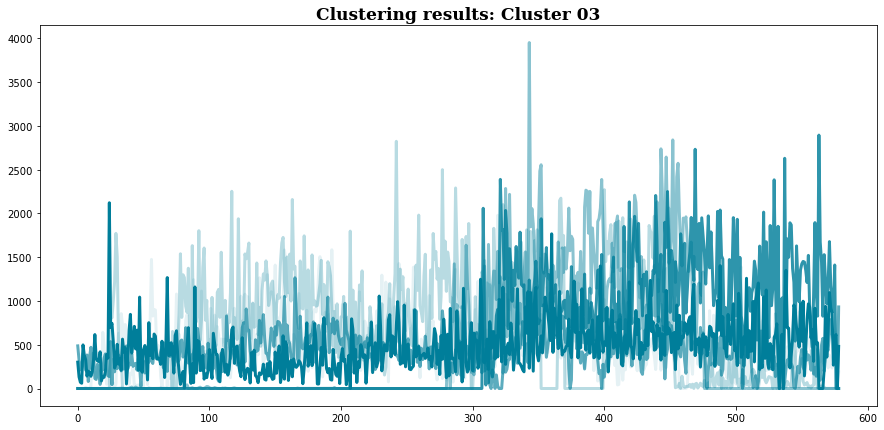

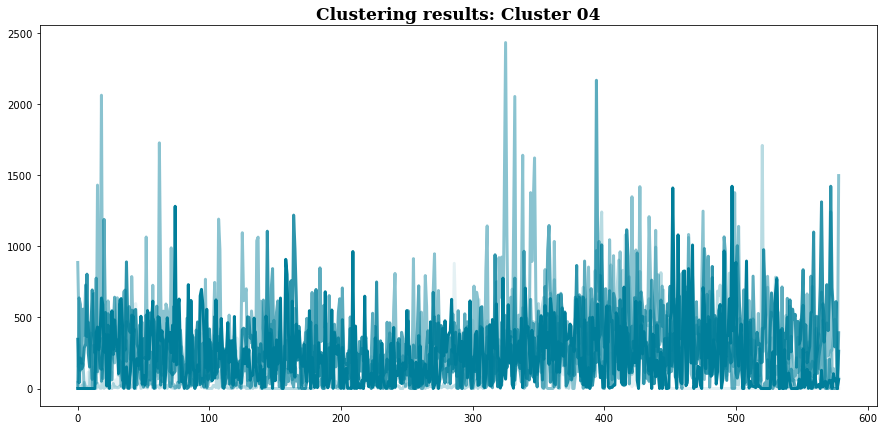

In [24]:
for i,g in enumerate([u00,u01,u02,u03]):
    plot_ts_cluster_results(g,i,n=n)

In [25]:
labs = KMeans(3).fit_predict(train[range(579)])

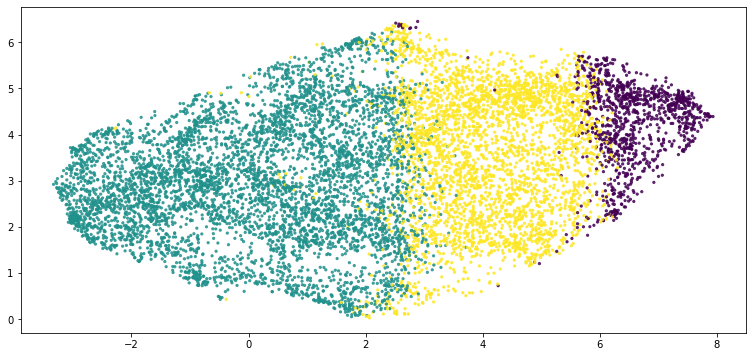

In [26]:
plt.figure(figsize=(13,6))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],c=labs,s=5, cmap='viridis',alpha=0.8)
plt.show()

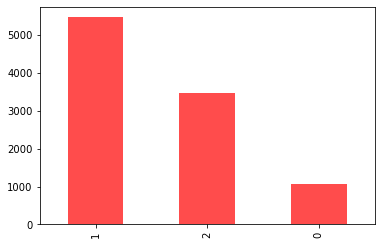

In [27]:
train['segment'] = labs
ax = train['segment'].value_counts().plot.bar(color='r',alpha=0.7)
plt.show()

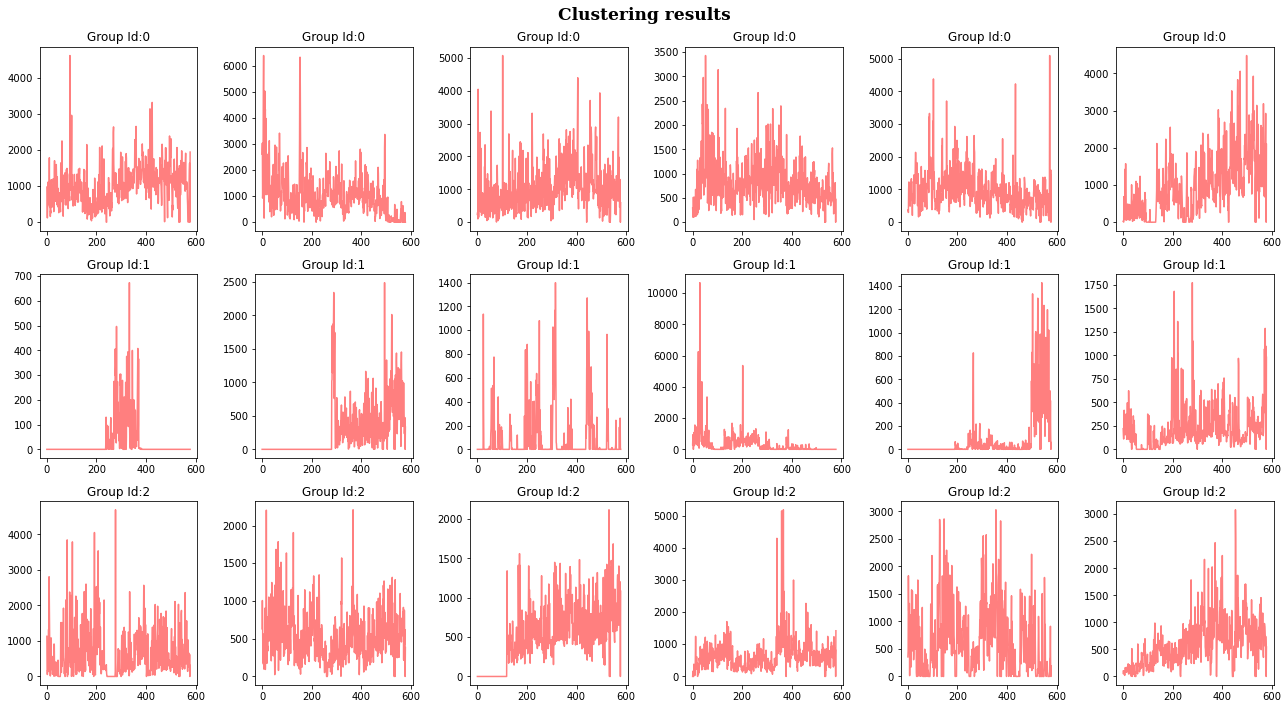

In [28]:
n = 6
fig,ax = plt.subplots(len(np.unique(labs)),n,figsize=(18,10))

u00 = train.query("segment==0")[range(579)].sample(n).values
u01 = train.query("segment==1")[range(579)].sample(n).values
u02 = train.query("segment==2")[range(579)].sample(n).values
# u03 = train.query("segment==3")[range(579)].sample(n).values

for i,g in enumerate([u00,u01,u02]):
    for j,usage in enumerate(g):
        ax[i][j].set_title(f"Group Id:{i}")
        ax[i][j].plot(usage,color='r',alpha=0.5)

fig.suptitle('Clustering results',fontfamily='serif',fontsize='17',fontweight='semibold')
plt.tight_layout()
plt.show()

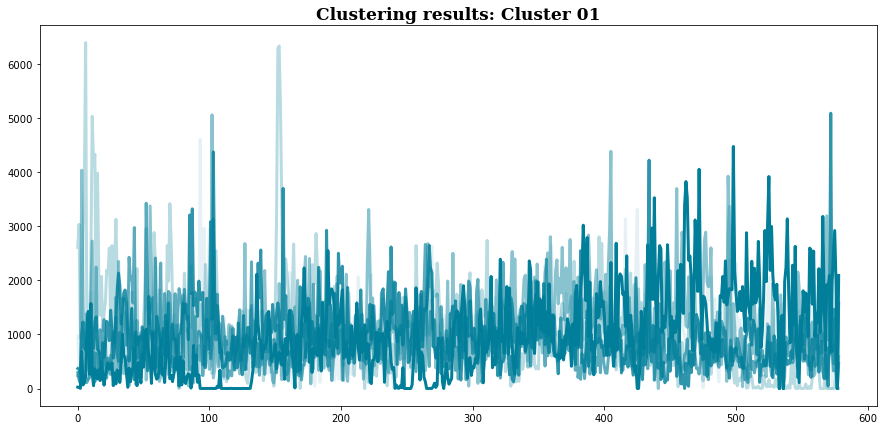

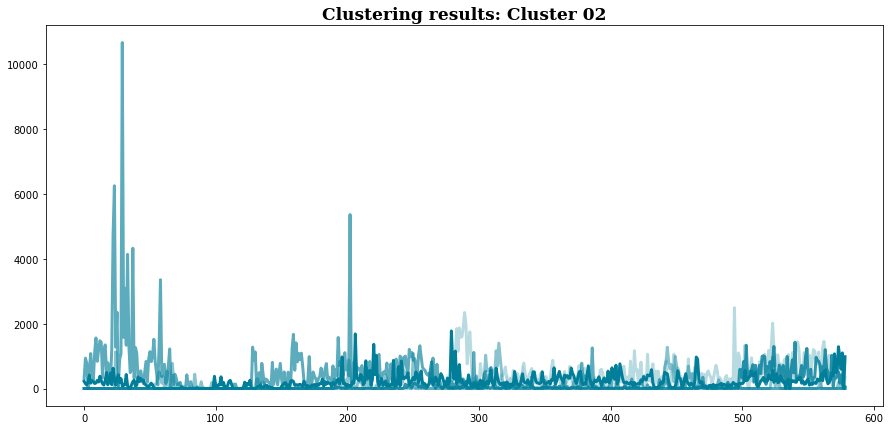

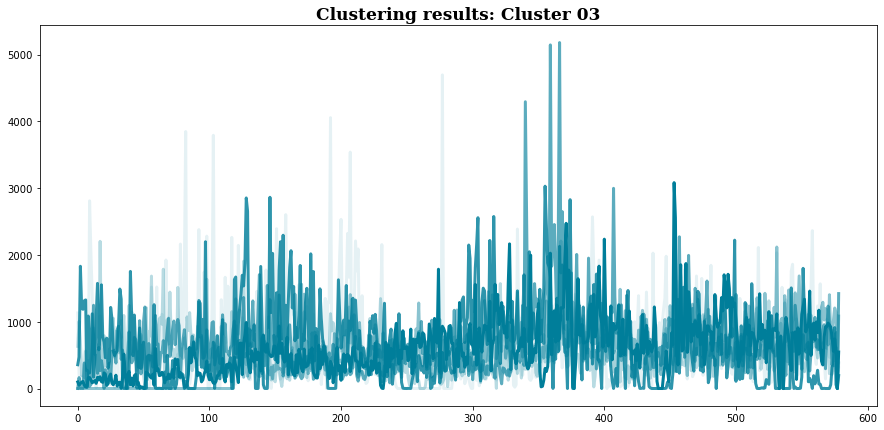

In [29]:
for i,g in enumerate([u00,u01,u02]):
    plot_ts_cluster_results(g,i,n=n)